In [1]:
## K-Nearest Neighbors

### O Modelo

In [2]:
from typing import List
from collections import Counter

# Função que conta os votos
def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

# Reduz k até encontrar um só vencedor
def majority_vote(labels: List[str]) -> str:
    """Supõe que os rótulos estão classificados do mais próximo para o mais distante"""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count for count in vote_counts.values() if count == winner_count])

    if num_winners == 1:
        return winner                           # vencedor único, então retorna ele
    else:
        return majority_vote(labels[:-1])      # tente novamente sem o mais distante

assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'


In [4]:
# Criando um classificador
import import_ipynb

from typing import NamedTuple
from linear_algebra import Vector, distance

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: Vector) -> str:
    # Classifique os pontos rotulados do mais próximo para o mais distante
    by_distance = sorted(labeled_points, key=lambda lp: distance(lp.point, new_point))

    # Encontre os rótulos dos k mais próximos
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    return majority_vote(k_nearest_labels)


### Exemplo: Conjunto de dados Iris

In [5]:
import requests

data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('iris.data', 'w') as f:
    f.write(data.text)



In [21]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
        """
        sepal_length, sepal_width, petal_length, petal_width, class
        """
        measurements = [float(value) for value in row[:-1]]
        # class is e.g. "Iris-virginica"; we just want "virginica"
        label = row[-1].split("-")[-1]
    
        return LabeledPoint(measurements, label)
    
with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]

# We'll also group just the points by species/label so we can plot them.
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

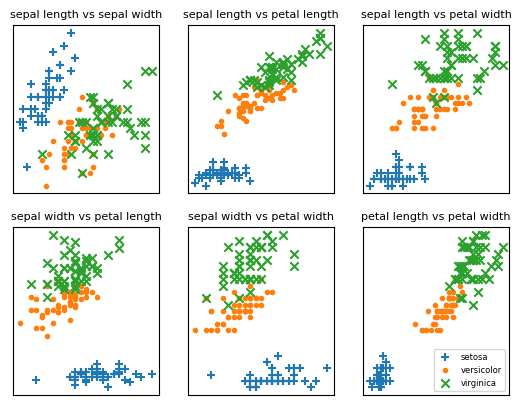

In [22]:
import matplotlib.pyplot as plt

metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']     # Temos 3 classes, então 3 marcadores

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]

        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)
ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

In [23]:
import random

from machine_learning import split_data

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)

assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

importing Jupyter notebook from machine_learning.ipynb


In [24]:
from typing import Tuple

# conte quantas vezes identificamos (previsto, real)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1
    
    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)


0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


### A maldição da dimensionalidade

In [25]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

In [26]:
# para cada dimensão de 1 a 100, vamos computador 10 mil distâncias e usá-las para computar a distância entre os pontos e a distância mínima entre os pontos em cada dimensão

import tqdm

dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)            # 10 mil pares aleatórios
    avg_distances.append(sum(distances) / 10000)        # obtenha a média
    min_distances.append(min(distances))                # obtenha a mínima

Curse of Dimensionality: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


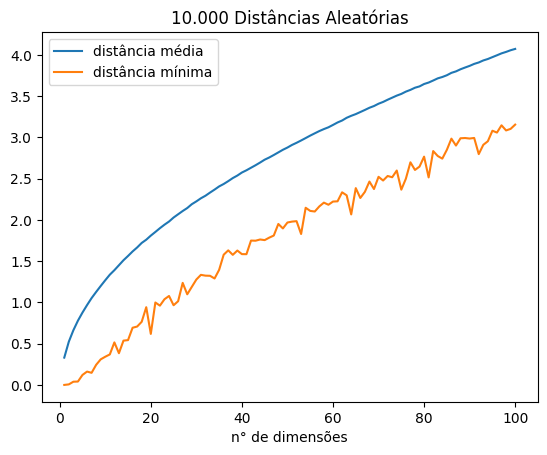

In [33]:
plt.plot(dimensions, avg_distances, label='distância média')
plt.plot(dimensions, min_distances, label='distância mínima')

plt.title("10.000 Distâncias Aleatórias")
plt.legend()
plt.xlabel("n° de dimensões")

plt.show()

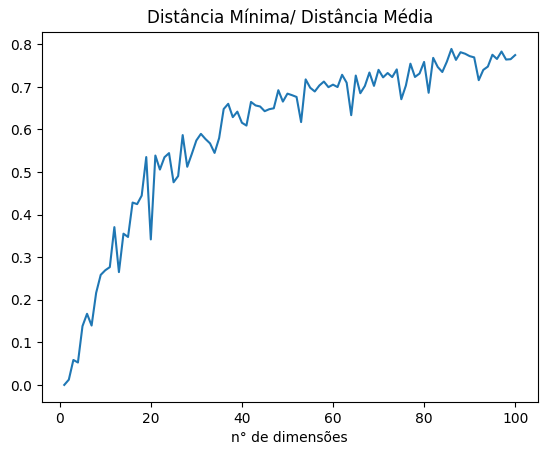

In [32]:
min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distances, avg_distances)]

plt.plot(dimensions, min_avg_ratio)
plt.title("Distância Mínima/ Distância Média")
plt.xlabel("n° de dimensões")
plt.show()